In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
import multiprocessing as mp
from sklearn.decomposition import PCA

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Predictive Coding Github Repository
sys.path.append('/home/dwyrick/Git/openscope_predictive_coding/')
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

#User
import openscope_predictive_coding.ophys.decoding_analysis.decoding as dc
import openscope_predictive_coding.ophys.response_analysis.utilities as openscope_utils

#Params
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
PlotDir = os.path.join(SaveDir,'plots')

In [2]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = '/srv/data/AllenInst/opc_analysis'

# Read in experiment manifest
manifest_file = '/srv/data/AllenInst/opc_analysis/opc_production_manifest.xlsx'
manifest = pd.read_excel(manifest_file)

# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']
areanames = np.unique(manifest['imaging_area'])

In [ ]:
manifest.head()

In [3]:
experiment_ids = manifest[(manifest.imaging_area=='VISp')].experiment_id.values
experiment_ids

array([8.13071318e+08, 8.17251851e+08, 8.26576489e+08, 8.27232898e+08,
       8.48690810e+08, 8.48691390e+08, 8.30075254e+08, 8.30688059e+08,
       8.35642229e+08, 8.35654507e+08, 8.33626456e+08, 8.36248932e+08,
       8.27235482e+08, 8.28959377e+08, 8.33611925e+08, 8.34251985e+08])

In [4]:
cell_metadata_df = pd.read_csv('/home/dwyrick/projects/predictive_coding/cell_metadata.csv')
cell_metadata_df.drop(columns='Unnamed: 0',inplace=True)
cell_metadata_df.drop_duplicates(subset='cell_specimen_id',inplace=True)
cell_metadata_df.set_index('cell_specimen_id', drop=True, inplace=True)

cell_metadata_df

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,experiment_date,specimen_id,depth,location,session_num,area,retrogradely_labeled,imaging_area,injection_area,projection_pathway
cell_specimen_id,,,,,,,,,,,,,,,,,,,
768915941,768898762,NaN,RSP,185,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_1,416366,2018-10-25,753787399,superficial,RSP_superficial,1,RSP,False,RSP,VISp,NaN
768915947,768898762,NaN,RSP,185,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_1,416366,2018-10-25,753787399,superficial,RSP_superficial,1,RSP,False,RSP,VISp,NaN
768915949,768898762,NaN,RSP,185,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_1,416366,2018-10-25,753787399,superficial,RSP_superficial,1,RSP,False,RSP,VISp,NaN
768915951,768898762,NaN,RSP,185,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_1,416366,2018-10-25,753787399,superficial,RSP_superficial,1,RSP,False,RSP,VISp,NaN
768915959,768898762,NaN,RSP,185,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_1,416366,2018-10-25,753787399,superficial,RSP_superficial,1,RSP,False,RSP,VISp,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838809358,838330377,NaN,VISpm,375,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_4,438382,2019-03-12,807303822,deep,VISpm_deep,4,VISpm,True,VISpm,VISp,FB
838809365,838330377,NaN,VISpm,375,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_4,438382,2019-03-12,807303822,deep,VISpm_deep,4,VISpm,False,VISpm,VISp,NaN
838809371,838330377,NaN,VISpm,375,Slc17a7,Camk2a-tTA;Ai93,Slc17a7;Camk2a-tTA;Ai93,behavior_session_4,438382,2019-03-12,807303822,deep,VISpm_deep,4,VISpm,False,VISpm,VISp,NaN


In [ ]:
np.unique(cell_metadata_df[cell_metadata_df['retrogradely_labeled'] == True]['projection_pathway'],return_counts=True)

In [5]:
areanames_bydepth, _ = np.unique(cell_metadata_df['location'],return_counts=True)
areanames_bydepth

array(['RSP_deep', 'RSP_superficial', 'VISp_deep', 'VISp_superficial',
       'VISpm_deep', 'VISpm_superficial'], dtype=object)

In [ ]:
stimulus_df['session_block_name'].unique()

In [6]:
# Concatenate data from all experiments to create pseudopopulation response arrays
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with
randctrl_pseudopop_responses = {}
transctrl_pseudopop_responses = {}
oddball_pseudopop_responses = {}

area = 'VISp'
for area in areanames:
    #For oddball block
    X_oddball, stimulus_df = dc.create_psuedopopulation(manifest, area, block='oddball')
    oddball_pseudopop_responses[area] = X_oddball
    
    #For randomized control pre block
    X_randctrl_pre, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_pre')

    #For randomized control pre block
    X_randctrl_post, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_post')
    randctrl_pseudopop_responses[area] = [X_randctrl_pre, X_randctrl_post]
    
    #For transition control block
    X_transctrl, stimulus_df = dc.create_psuedopopulation(manifest, area, block='transition_control')
    transctrl_pseudopop_responses[area] = X_transctrl
    

/home/dwyrick/miniconda3/envs/al/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dwyrick/miniconda3/envs/al/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


RSP pseudopopulation created for the oddball block: 1628 neurons from 12 experiments
RSP pseudopopulation created for the randomized_control_pre block: 1628 neurons from 12 experiments
RSP pseudopopulation created for the randomized_control_post block: 1628 neurons from 12 experiments
RSP pseudopopulation created for the transition_control block: 1628 neurons from 12 experiments
VISp pseudopopulation created for the oddball block: 2299 neurons from 15 experiments
VISp pseudopopulation created for the randomized_control_pre block: 2299 neurons from 15 experiments
VISp pseudopopulation created for the randomized_control_post block: 2299 neurons from 15 experiments
VISp pseudopopulation created for the transition_control block: 2299 neurons from 15 experiments
VISpm pseudopopulation created for the oddball block: 2071 neurons from 22 experiments
VISpm pseudopopulation created for the randomized_control_pre block: 2071 neurons from 22 experiments
VISpm pseudopopulation created for the rand

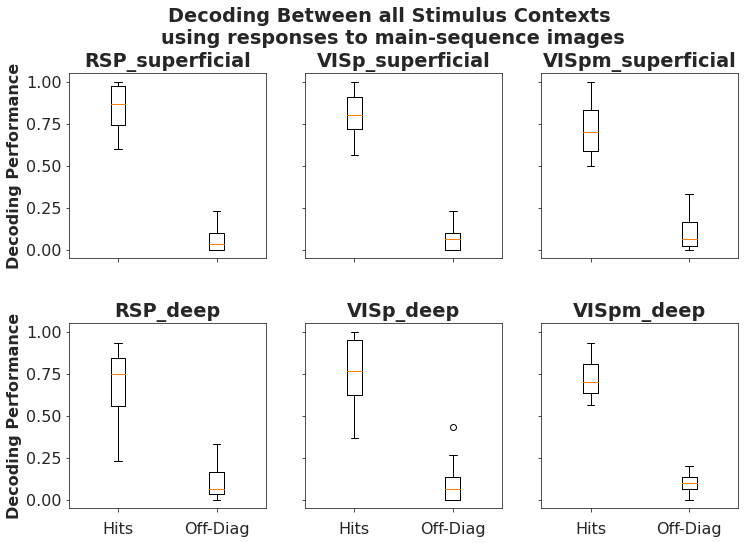

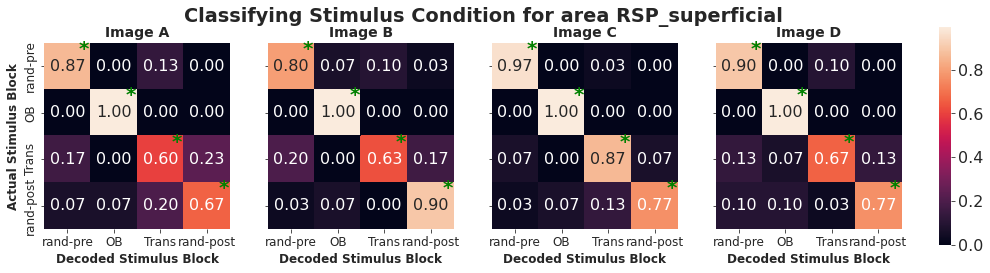

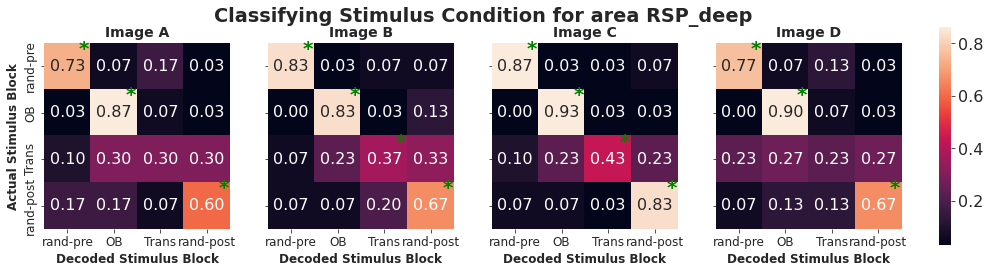

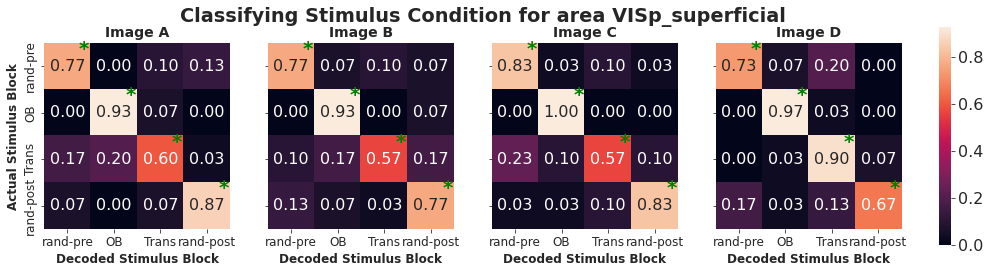

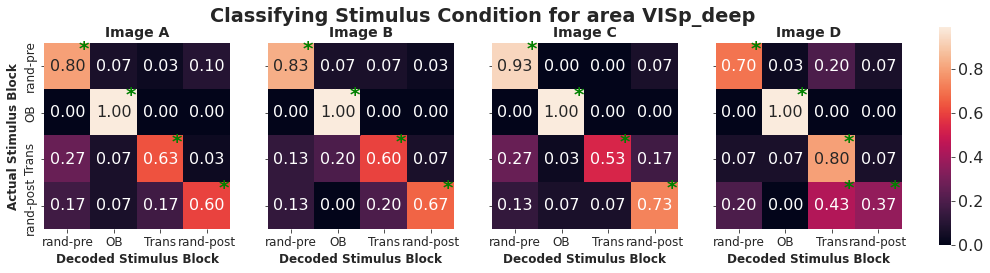

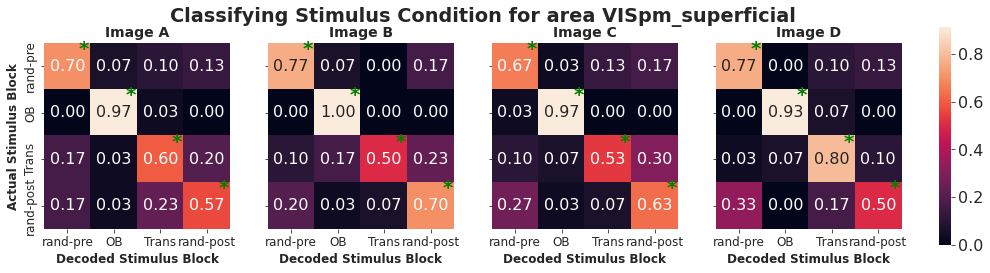

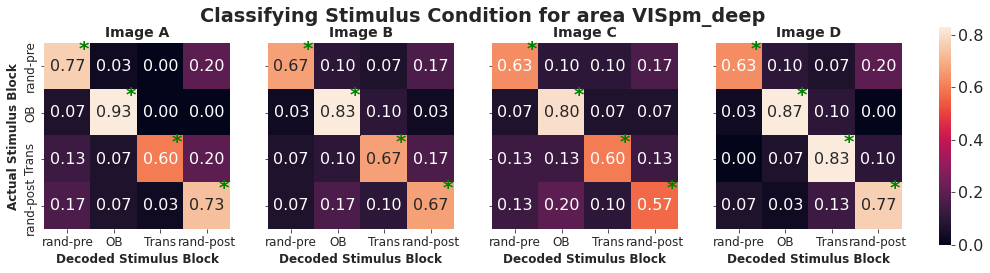

In [8]:
#Let's decode stimulus blocks from each other based on responses to MS images

method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

    
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get data for this area
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
        
        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl_pre.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]
            indy_post = np.where(Y_randctrl_post == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_randctrl_pre[indy_pre,:],X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:],X_randctrl_post[indy_post,:]))
            Y = np.hstack([np.repeat(i,30) for i in range(nClasses)])

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

#                 pdb.set_trace()
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_confusion_matrices(confusion_mat,confusion_z,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_avg-over-ms_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(nClasses)])
        offdiag_hits = np.concatenate([confusion_mat[i][off_diagonal_indy] for i in range(nClasses)])
        
        axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to main-sequence images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_{}_{}.png'.format(method,classifier)))

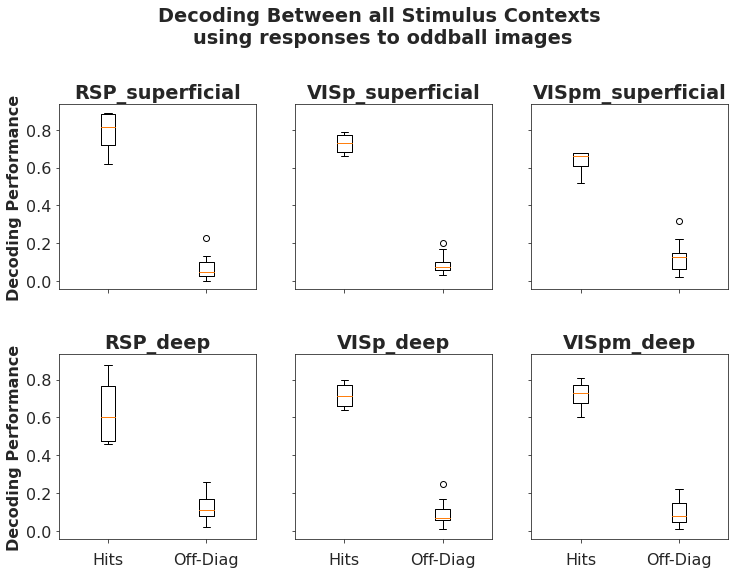

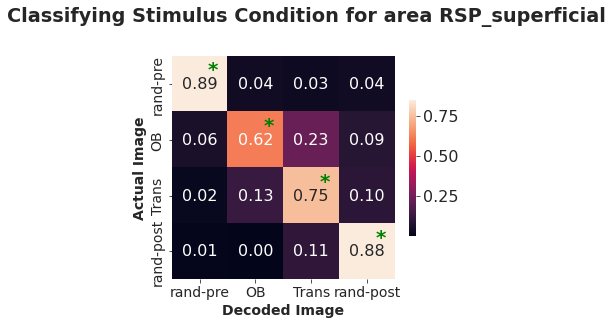

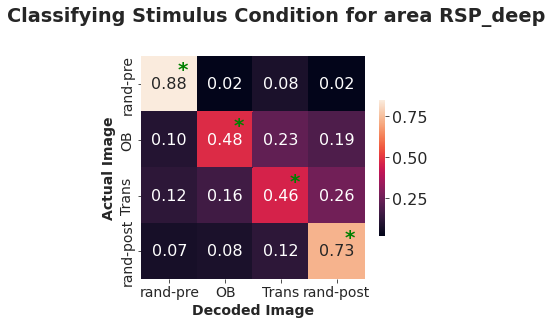

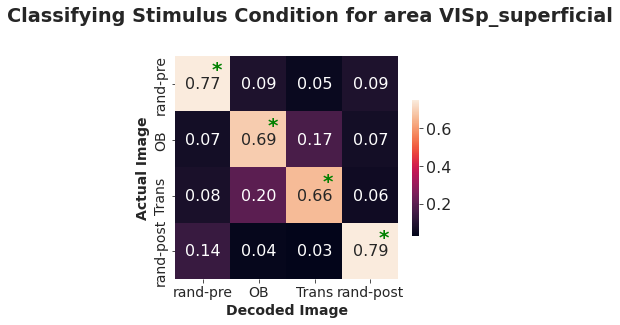

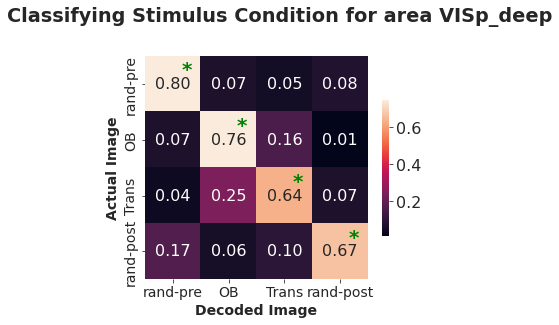

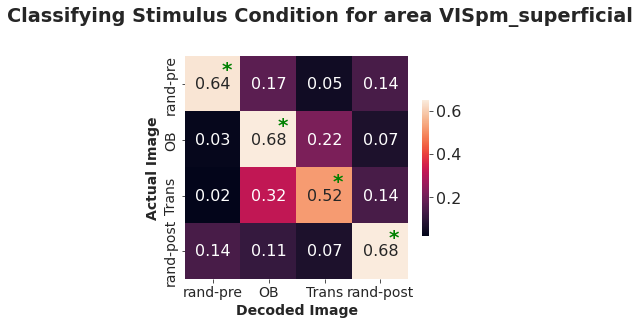

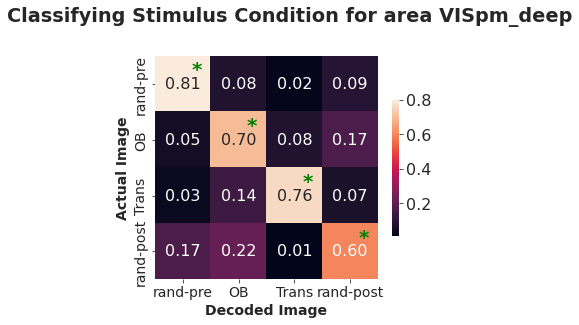

In [9]:
#Let's decode stimulus blocks from each other based on responses to oddball images

method='kfold'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

    
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get data for this area
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
        
        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        
    
        indy_list = []; indy_list2 = []; indy_list3 = []
        for iImg, img_ID in enumerate(oddball_ids):
            tmp = np.where(Y_randctrl_pre == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list.append(tmp[:10])
            
            tmp = np.where(Y_randctrl_post == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list2.append(tmp[:10])
            
            tmp = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list3.append(tmp[:10])
            
        indy_randctrlpre = np.concatenate(indy_list)
        indy_randctrlpost = np.concatenate(indy_list2)
        indy_transctrl = np.concatenate(indy_list3)

        #Construct X and Y from both blocks
        X = np.vstack((X_randctrl_pre[indy_randctrlpre,:],X_oddball,X_transctrl[indy_transctrl,:],X_randctrl_post[indy_randctrlpost,:]))
        Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])
        
        Y_sort = np.concatenate((['{}_0'.format(int(Y_randctrl_pre[ii])) for ii in indy_randctrlpre],['{}_1'.format(int(yy)) for yy in Y_oddball],['{}_2'.format(int(Y_transctrl[ii])) for ii in indy_transctrl],['{}_3'.format(int(Y_randctrl_post[ii])) for ii in indy_randctrlpost]))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]
            print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

        fpath = os.path.join(SaveDir,'StimulusBlocks_oddballimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_usingoddballs_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat)
        offdiag_hits = confusion_mat[off_diagonal_indy] 
        
        axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')
            
#         plt.show()
#         pdb.set_trace()
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to oddball images',y=01.05)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingoddballs{}_{}.png'.format(method,classifier)))

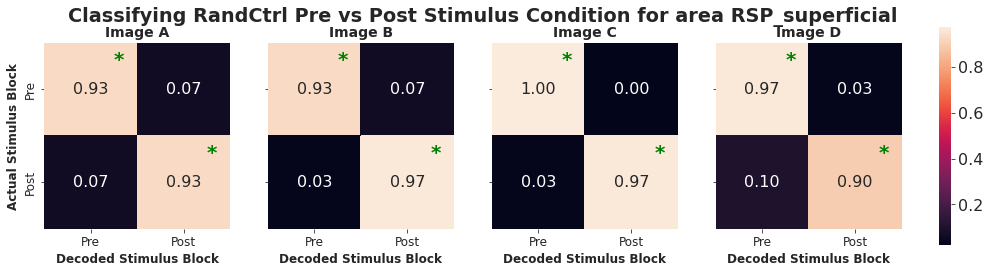

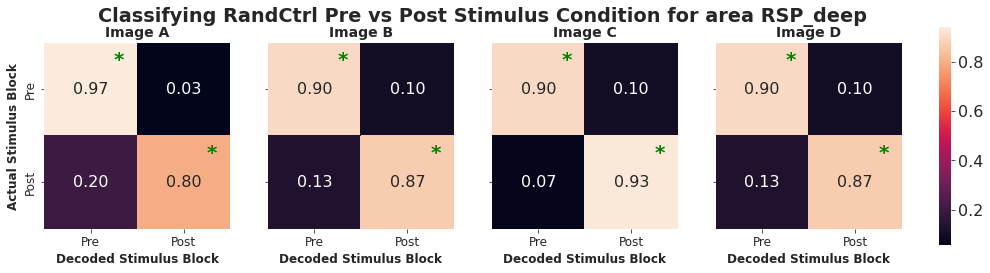

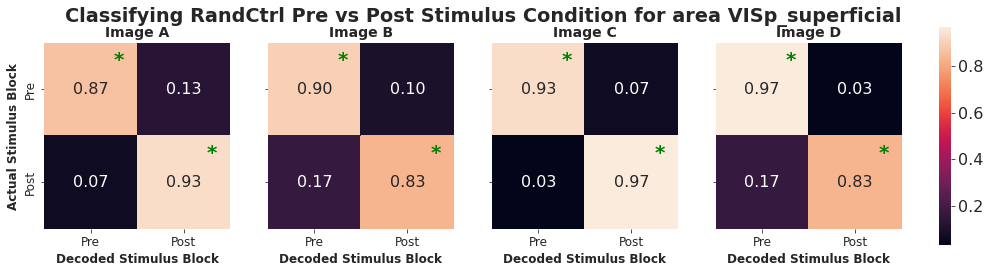

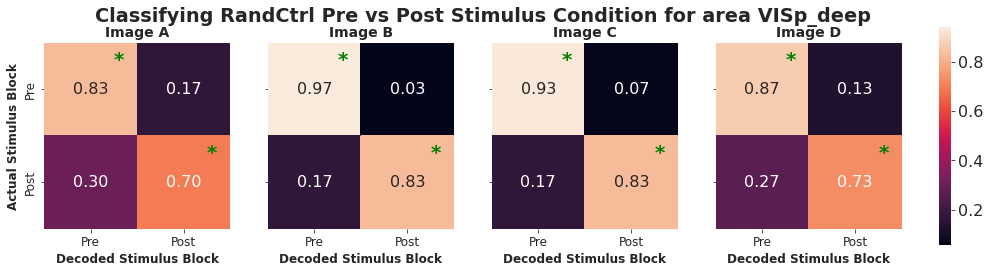

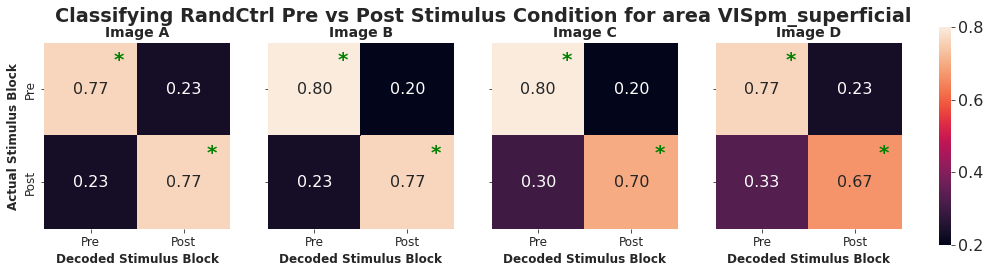

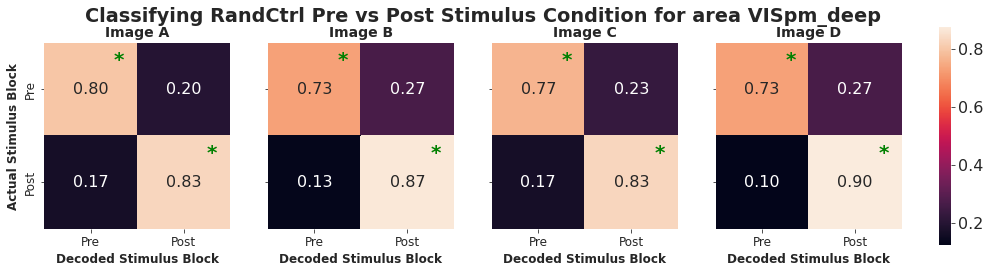

In [11]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context

method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
#         fig, axes = plt.subplots(1,2,figsize=(10,5))
        #Get data for this area
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
            
        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl_pre.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
            indy_post = np.where(Y_randctrl_post == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_randctrl_pre[indy_pre,:],X_randctrl_post[indy_post,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

#                 pdb.set_trace()
        fpath = os.path.join(SaveDir,'RandomizedCtrl_PreVsPost_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_confusion_matrices(confusion_mat,confusion_z,plot_titles=['A','B','C','D'],class_labels=['Pre','Post'])
        plt.suptitle('Classifying RandCtrl Pre vs Post Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrl_PreVsPost_avg-over-ms_{}_{}_{}.png'.format(locstr,method,classifier)))
        
#         plt.show()
#         pdb.set_trace()

In [12]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    
        #Get trials where MS images were presented from the randomized_ctrl block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
            
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
                
                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)
            
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        title = 'Classifying stimulus condition: Sequence vs Transition Control for {}'.format(locstr)
        dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'],title=title)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_{}_{}_{}.png'.format(locstr,method,classifier)))

NameError: name 'X_randctrl' is not defined

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context

method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)
            #Get data for this area
            X_randctrl_all = randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth]
            X_oddball_all = oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth]

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(X_randctrl_all, stimulus_df, block=block_str, trial_type='ABCD')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(X_oddball_all, stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            pdb.set_trace()
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
                
                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
            
                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],nKfold=5,classifier=classifier,method=method,plot_shuffle=False,parallel=False)

#                 pdb.set_trace()
            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Rand-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-ms_{}_{}_{}.png'.format(locstr,method,classifier)))

## Let's see if we can decode the transition control vs oddball context 
using trials where the MS images were presented

In [13]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    
        #Get trials where MS images were presented from the randomized_ctrl block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
            
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
                
                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)
            
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        title = 'Classifying stimulus condition: Sequence vs Transition Control for {}'.format(locstr)
        dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'],title=title)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_{}_{}_{}.png'.format(locstr,method,classifier)))

NameError: name 'X_randctrl' is not defined

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))            
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])
            
        pdb.set_trace()

        
    

In [ ]:
st.norm.sf(confusion_z[-1])

## What if we compare transition control with randomized control?
Give we can decode the oddball context from both the randomized control and transition control, we might expect the 2 to be indistiguishable...
But that's not what we find!

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

            #Get trials where MS images were presented from the transition_control block
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
                
                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    #                     print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            title = 'Classifying stimulus condition: TransCtrl vs RandCtrl-{} for {}'.format(pstr,locstr)
            dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['TransCtrl','RandCtrl'],title=title)
            plt.savefig(os.path.join(PlotDir,'RandomizedCtrl-{}VsTransitionCtrl_{}_{}.png'.format(pstr,locstr,method,classifier)))


## Let's use the oddball images to see if we decode context
Again, let's start with oddball vs randomized control

In [ ]:
# Let's decode stimulus context per oddball image; i.e. gather trials where an oddball image was presented from both conditions and decode stimulus context that way;
# We will have 10 confusion matrices which we will average over
# The problem with this is that each oddball is only presented 10 times in the oddball block, hence why we are doing leave-1-out x-validation
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]
                np.random.shuffle(indy_randctrl)

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl[:10],:]))
                Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    #                     print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Randomized Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for {} using\n each Oddball Image separately'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

In [ ]:
#Let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
method='kfold'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

            indy_list = []
            for iImg, img_ID in enumerate(oddball_ids):
                tmp = np.where(Y_randctrl == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list.append(tmp[:10])

            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_randctrl = np.concatenate(indy_list)

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball,X_randctrl[indy_randctrl,:]))
            Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_randctrl))))

            #Create this vector so that the cross validation conserves the proportion of trials for each oddball image in the training and test sets
            Y_sort = np.concatenate((['{}_0'.format(int(yy)) for yy in Y_oddball],['{}_1'.format(int(Y_randctrl[i])) for i in indy_randctrl]))
#             pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)
                    

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgTogether_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['Sequence','Rand-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_all-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

## What about oddball vs transition control?
again using the oddball images separately, then averaging over them

In [ ]:
classifier = 'nearest_neighbor'
method='L1O'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

        #Get trials where odbball images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(indy_transctrl)

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl[:10],:]))
            Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['Sequence','Trans-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition\n using all Oddball Images; {}'.format(locstr),y=0.975)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

In [ ]:
#For completeness sakes, let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
classifier = 'SVM'
method='kfold'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        #Since the transition control block has more than 10 trials per oddball image, we have to take 10 randomly
        indy_list = []
        for img_ID in oddball_ids:
            tmp = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list.append(tmp[:10])

        indy_transctrl = np.concatenate(indy_list)

        #Construct X and Y from both blocks
        X = np.vstack((X_oddball,X_transctrl[indy_transctrl,:]))
        Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_transctrl))))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)
               

        #Perform cross-validated decoding analysis
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'TransitionCtrl-{}VsOddballBlocks_OBimgTogether_{}_{}.mat'.format(pstr,locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['Sequence','Transition Ctrl'])
        plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_all-oddballs_{}_{}.png'.format(locstr,classifier)))

## What about transition control vs randomized control?
using the oddball images 

In [ ]:
classifier = 'nearest_neighbor'
method='L1O'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the transition_control block
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'TransCtrl vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Transition Ctrl','Randomized Ctrl'],title=title)

        plt.suptitle('Classifying Stimulus Condition for area {} using oddball images'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsTransitionCtrl_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

## Let's try to decode trials in which image A followed image D vs an oddball
i.e. DA vs XA transitions in the transition control

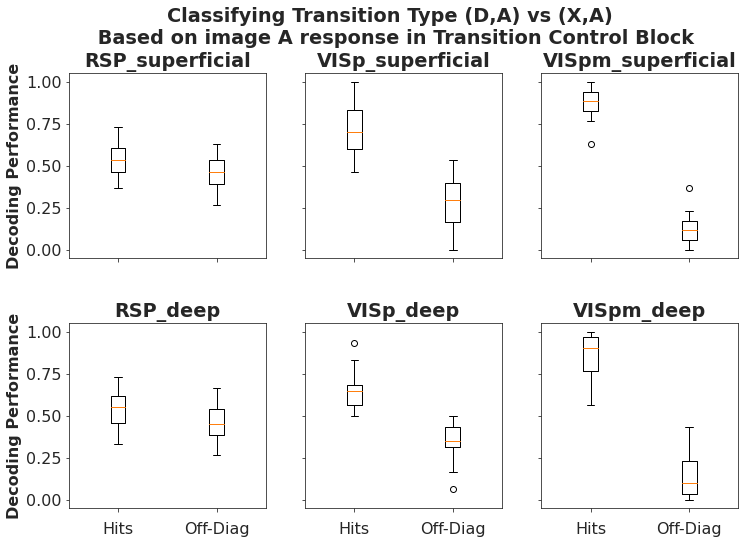

In [11]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='L1O'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

for ii, area in enumerate(areanames):
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)

        fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])
            
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(oddball_ids))])
        offdiag_hits = np.concatenate([confusion_mat[i][off_diagonal_indy] for i in range(len(oddball_ids))])
        _, pval = st.ttest_ind(diag_hits,offdiag_hits)
        
        if pval < 0.05:
            axes2[jj,ii].set_title('{}*'.format(locstr))
        else:
            axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')
            
fig2.suptitle('Classifying Transition Type (D,A) vs (X,A) \n Based on image A response in Transition Control Block',y=0.995)
fig2.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_BOXPLOT_{}_{}.png'.format(method,classifier)))


In [6]:
off_diagonal_indy

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7,
        8, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9,
        9, 9]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7,
        8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9,
        9, 0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5,
        0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6,
        7, 8]))

## What about in the oddball block: (X,A) vs (D,A)

In [ ]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')


nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

for ii, area in enumerate(areanames):
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
       
        fpath = os.path.join(SaveDir,'DAvsXA_Oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])

#         #Plot shuffle distributions
#         dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['(D,A)','(X,A)'])
#         plt.suptitle('Classifying Transition Type in oddball block\n Based on image A response; {}'.format(locstr),y=0.925)
#         # plt.show()
#         # pdb.set_trace()
#         plt.savefig(os.path.join(PlotDir,'DAvsXA_Oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(len(oddball_ids))])
        offdiag_hits = np.concatenate([confusion_mat[i][off_diagonal_indy] for i in range(len(oddball_ids))])
#         _, pval = st.ttest_ind(diag_hits,offdiag_hits)
        
        axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')
            
fig2.suptitle('Classifying Transition Type (D,A) vs (X,A) \n Based on image A response in Oddball Block',y=0.995)
fig2.savefig(os.path.join(PlotDir,'DAvsXA_Odbball-block_BOXPLOT_{}_{}.png'.format(method,classifier)))

        
        
        

In [13]:
confusion_mat.shape

(2, 2)

## Image Identity
Let's see if we can decode image identity in the randomized blocks using the pseudopopulation 

In [ ]:
np.unique(Y_transctrl,return_counts=True)

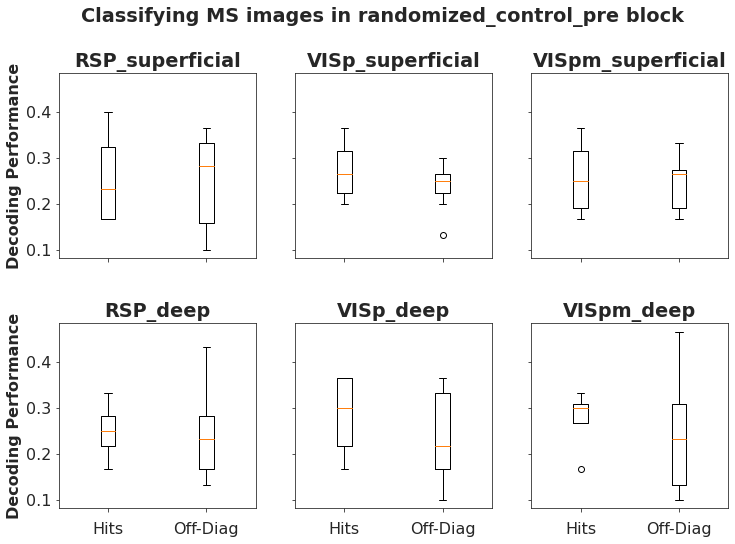

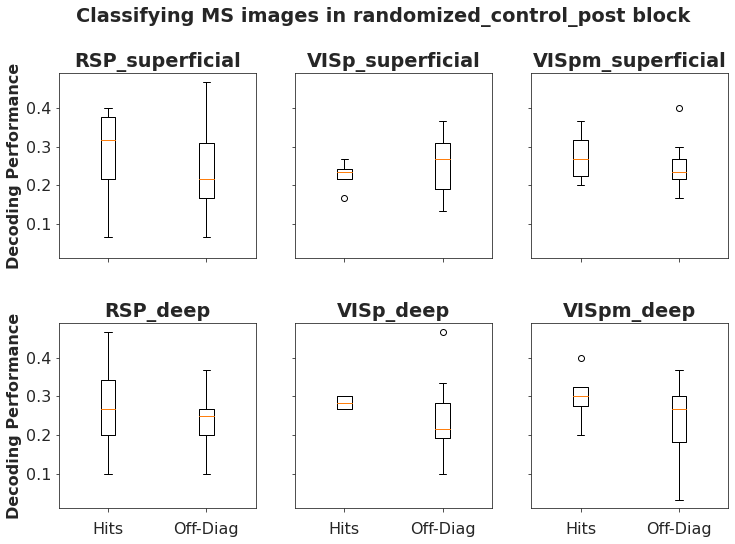

In [17]:
classifier = 'nearest_neighbor'
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')



nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

for pstr in ['pre','post']: 

    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    for ii,area in enumerate(areanames):
        for jj, depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            block_str = 'randomized_control_{}'.format(pstr)
           
            fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
            with h5py.File(fpath,'r') as h5results:
                confusion_mat = np.array(h5results['confusion_mat'])
                confusion_shf = np.array(h5results['confusion_shf'])
                confusion_z = np.array(h5results['confusion_z'])

#             pdb.set_trace()
             #Sparate diagonal and off-diagonal performance
            diag_hits = np.diag(confusion_mat) 
            offdiag_hits = confusion_mat[off_diagonal_indy]

            _, pval = st.ttest_ind(diag_hits,offdiag_hits)
            if pval < 0.05:
                axes2[jj,ii].set_title('{}*'.format(locstr))
            else:
                axes2[jj,ii].set_title(locstr)

            axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
            if jj == 1:
                axes2[jj,ii].set_xticks([1,2])
                axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                axes2[jj,ii].set_ylabel('Decoding Performance')
            
    fig2.suptitle('Classifying MS images in {} block'.format(block_str),y=0.995)
    fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-{}-block_BOXPLOT_{}_{}.png'.format(pstr,method,classifier)))


## What if we combine randomized control pre and post?

fpath## Let's see if we can decode image identity in the transition control block
using the second images of the (D,A),(A,B),(B,C),(C,D) transitions 

In [31]:
areanames = ['VISp','VISpm','RSP']

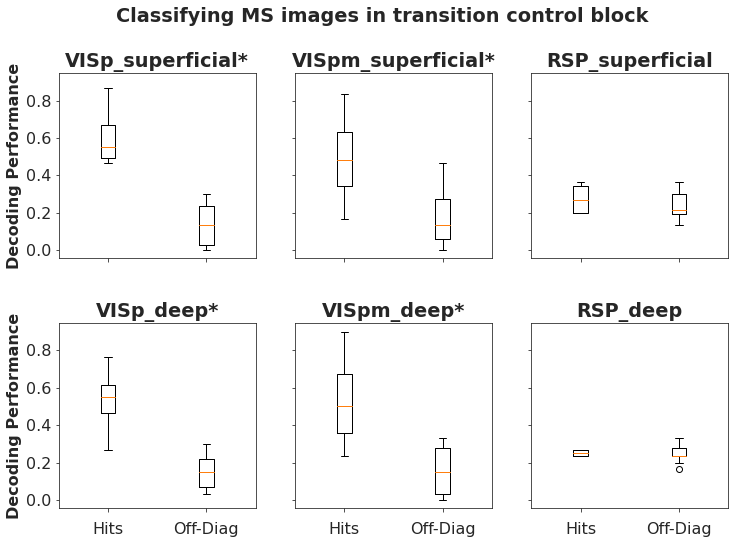

In [32]:
classifier = 'nearest_neighbor'
method='L1O'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')



nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii,area in enumerate(areanames):
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)

#         fpath = os.path.join(SaveDir,'mainseq_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        fpath = os.path.join(SaveDir,'mainseq_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])

#             pdb.set_trace()
         #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat) 
        offdiag_hits = confusion_mat[off_diagonal_indy]

        _, pval = st.ttest_ind(diag_hits,offdiag_hits)
        if pval < 0.05:
            axes2[jj,ii].set_title('{}*'.format(locstr))
        else:
            axes2[jj,ii].set_title(locstr)

        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')

fig2.suptitle('Classifying MS images in transition control block',y=0.995)
fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_trans-ctrl-block_BOXPLOT_{}_{}.png'.format(method,classifier)))


## Can we decode image identity in the oddball block?
Let's use the first 240 trials, then 240 trials in the middle, then the last 240 trials

In [ ]:
3320 - 3080

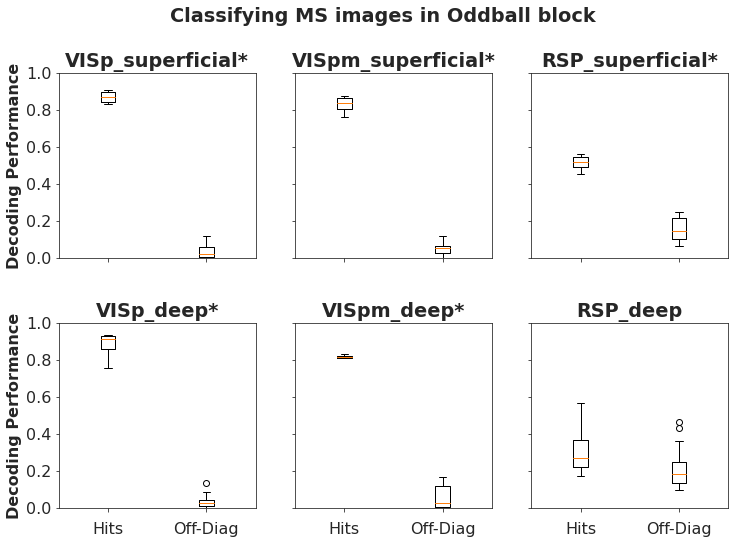

In [45]:
method='kfold'

reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
slice_list = [slice(0,120),slice(3000,3400),slice(6160,6400)]
slice_str = ['first120','middle240','last240']
sl_val = slice_list[0]
sl_str = slice_str[0]

slice_list = [slice(0,1000),slice(3000,3400),slice(6160,6400)]
slice_str = ['first1000','middle240','last240']
sl_val = slice_list[0]
sl_str = slice_str[0]

slice_list = [slice(0,2000),slice(3000,5000),slice(6160,6400)]
slice_str = ['first2000','middle2000','last240']
sl_val = slice_list[1]
sl_str = slice_str[1]

nClasses = 4
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))



fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)

for ii,area in enumerate(areanames):
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])


         #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat) 
        offdiag_hits = confusion_mat[off_diagonal_indy]

        _, pval = st.ttest_ind(diag_hits,offdiag_hits)
        if pval < 0.05:
            axes2[jj,ii].set_title('{}*'.format(locstr))
        else:
            axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].set_ylim([0,1])
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')

fig2.suptitle('Classifying MS images in Oddball block',y=0.995)
fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_BOXPLOT_{}_{}_{}.png'.format(sl_str,method,classifier)))



In [ ]:
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,3,figsize=(15,5))
        for ii,(sl_val,sl_str) in enumerate(zip(slice_list,slice_str)):
            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_oddball)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)


            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=sl_str,annot=True)
        plt.suptitle('Classifying MS Images for {}, Oddball block, {} classifier'.format(locstr,classifier))
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## What if we use all of the trials possible?

## Oddball images from the transition control block

## Oddball images from the transition control block

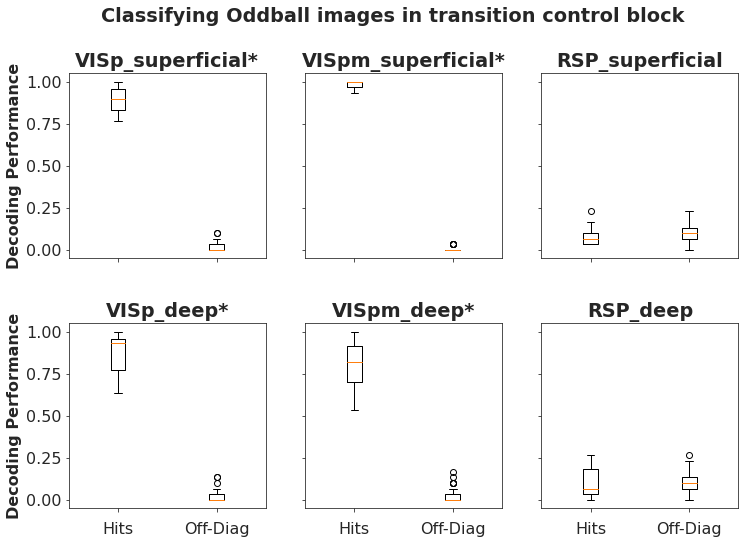

In [39]:

method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 10
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii,area in enumerate(areanames):
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        fpath = os.path.join(SaveDir,'X-img_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])


         #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat) 
        offdiag_hits = confusion_mat[off_diagonal_indy]

        _, pval = st.ttest_ind(diag_hits,offdiag_hits)
        if pval < 0.05:
            axes2[jj,ii].set_title('{}*'.format(locstr))
        else:
            axes2[jj,ii].set_title(locstr)

        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')

fig2.suptitle('Classifying Oddball images in transition control block',y=0.995)
fig2.savefig(os.path.join(PlotDir,'X-img_decoding_transctrl-blocks_BOXPLOT_{}_{}.png'.format(method,classifier)))



## Oddball images from the oddball block

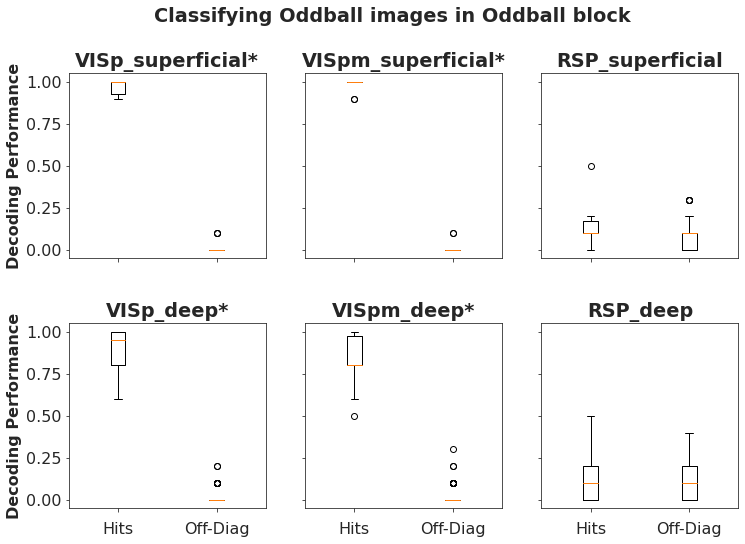

In [40]:

method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 10
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii,area in enumerate(areanames):
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        fpath = os.path.join(SaveDir,'X-img_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])


         #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat) 
        offdiag_hits = confusion_mat[off_diagonal_indy]

        _, pval = st.ttest_ind(diag_hits,offdiag_hits)
        if pval < 0.05:
            axes2[jj,ii].set_title('{}*'.format(locstr))
        else:
            axes2[jj,ii].set_title(locstr)

        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')

fig2.suptitle('Classifying Oddball images in Oddball block',y=0.995)
fig2.savefig(os.path.join(PlotDir,'X-img_decoding_oddball-block_BOXPLOT_{}_{}.png'.format(method,classifier)))



In [ ]:
method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
#         pdb.set_trace()
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,clabels=oddball_ids,classifier=classifier)

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=oddball_ids)

        fpath = os.path.join(SaveDir,'X-img_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

#         with h5py.File(fpath,'r') as h5file:
#             confusion_mat = np.array(h5file['confusion_mat'])
#             confusion_z = np.array(h5file['confusion_z'])

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=locstr,annot=False)
    plt.suptitle('Classifying Oddball Images for oddball block, {} classifier'.format(classifier),y=0.925)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_oddball-blocks_{}_{}_{}.png'.format(locstr,method,classifier)))

### Try to decode oddball images vs the previous main sequence in the oddball block
ABCD---X; i.e. the ABC trials are as far away from an oddball presentation as possible

In [ ]:
PlotDir

In [ ]:
classifier = 'nearest_neighbor'

method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
 
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCDX')
        
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])
            

        fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=locstr,annot=True)
    plt.suptitle('Oddball vs Previous Main-Sequence Images, ABCD---X, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}-areas_{}.png'.format(depthstr,classifier)))

### Try to decode oddball images vs the main sequence immediately following the oddball
XABCD i.e. the ABCD trials are as close to the oddball presentations as possible

In [ ]:
method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='XABCD')

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=locstr,annot=True)
    plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}-areas_{}_{}.png'.format(depthstr,method,classifier)))